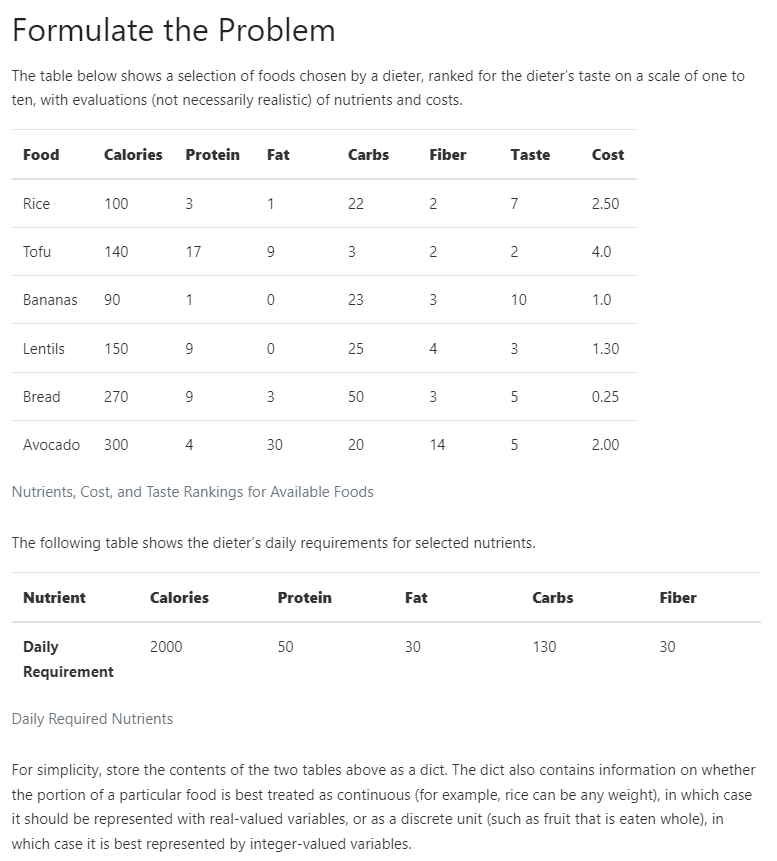

It can be used to simulate pizza problem

In [4]:
import dimod
import dwave.inspector
import dwave.system

# define problmen
foods = {
  'rice': {'Calories': 100, 'Protein': 3, 'Fat': 1, 'Carbs': 22, 'Fiber': 2,
           'Taste': 7, 'Cost': 2.5, 'Units': 'continuous'},
  'tofu': {'Calories': 140, 'Protein': 17, 'Fat': 9, 'Carbs': 3, 'Fiber': 2,
           'Taste': 2, 'Cost': 4.0, 'Units': 'continuous'},
  'banana': {'Calories': 90, 'Protein': 1, 'Fat': 0, 'Carbs': 23, 'Fiber': 3,
             'Taste': 10, 'Cost': 1.0, 'Units': 'discrete'},
  'lentils': {'Calories': 150, 'Protein': 9, 'Fat': 0, 'Carbs': 25, 'Fiber': 4,
              'Taste': 3, 'Cost': 1.3, 'Units': 'continuous'},
  'bread': {'Calories': 270, 'Protein': 9, 'Fat': 3, 'Carbs': 50, 'Fiber': 3,
            'Taste': 5, 'Cost': 0.25, 'Units': 'continuous'},
  'avocado': {'Calories': 300, 'Protein': 4, 'Fat': 30, 'Carbs': 20, 'Fiber': 14,
              'Taste': 5, 'Cost': 2.0, 'Units': 'discrete'}}

#define goals
min_nutrients = {"Protein": 50, "Fat": 30, "Carbs": 130, "Fiber": 30}
max_calories = 2000


In [5]:
#define variables
quantities = [dimod.Real(f"{food}") if foods[food]["Units"] == "continuous"
                                    else dimod.Integer(f"{food}")
                                    for food in foods.keys()]

# bound to calory
for ind, food in enumerate(foods.keys()):
  ub = max_calories / foods[food]["Calories"]
  quantities[ind].set_upper_bound(food, ub)

In [6]:
#Maximum amout of rice
quantities[0].upper_bound("rice")

20.0

In [7]:
#define objective function
cqm = dimod.ConstrainedQuadraticModel()
def total_mix(quantity, category):
  return sum(q * c for q, c in zip(quantity, (foods[food][category] for food in foods.keys())))

cqm.set_objective(-total_mix(quantities, "Taste") + 6*total_mix(quantities, "Cost"))

In [8]:
# Constrains
# Calories not more than defined
cqm.add_constraint(total_mix(quantities, "Calories") <= max_calories, label="Calories")
'Calories'
# Other elemwents at least
for nutrient, amount in min_nutrients.items():
  cqm.add_constraint(total_mix(quantities, nutrient) >= amount, label=nutrient)

In [11]:
# accessing constrains
list(cqm.constraints.keys())
print(cqm.constraints["Calories"].to_polystring())
print(cqm.constraints["Protein"].to_polystring())

100*rice + 140*tofu + 90*banana + 150*lentils + 270*bread + 300*avocado <= 2000
3*rice + 17*tofu + banana + 9*lentils + 9*bread + 4*avocado >= 50


In [12]:
# Solving isssue by sampler
from dwave.system import LeapHybridCQMSampler
sampler = LeapHybridCQMSampler() 
sampleset = sampler.sample_cqm(cqm)                    
feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)   
print("{} feasible solutions of {}.".format(len(feasible_sampleset), len(sampleset)))   

31 feasible solutions of 49.


In [13]:
# better results presentation
def print_diet(sample):
   diet = {food: round(quantity, 1) for food, quantity in sample.items()}
   print(f"Diet: {diet}")
   taste_total = sum(foods[food]["Taste"] * amount for food, amount in sample.items())
   cost_total = sum(foods[food]["Cost"] * amount for food, amount in sample.items())
   print(f"Total taste of {round(taste_total, 2)} at cost {round(cost_total, 2)}")
   for constraint in cqm.iter_constraint_data(sample):
      print(f"{constraint.label} (nominal: {constraint.rhs_energy}): {round(constraint.lhs_energy)}")

In [14]:
# print best restult
best = feasible_sampleset.first.sample                       
print_diet(best)     

Diet: {'avocado': 1.0, 'banana': 6.0, 'bread': 4.1, 'lentils': 0.3, 'rice': 0.0, 'tofu': 0.0}
Total taste of 86.56 at cost 9.46
Calories (nominal: 2000): 2000
Protein (nominal: 50): 50
Fat (nominal: 30): 42
Carbs (nominal: 130): 372
Fiber (nominal: 30): 46


In [15]:
# try to find solution that tasted the best
cqm.set_objective(-total_mix(quantities, "Taste"))
sampleset_taste = sampler.sample_cqm(cqm)                     
feasible_sampleset_taste = sampleset_taste.filter(lambda row: row.is_feasible)  
best_taste = feasible_sampleset_taste.first                   
print(round(best_taste.energy))                               
print_diet(best_taste.sample) 

-177
Diet: {'avocado': 0.0, 'banana': 17.0, 'bread': 0.0, 'lentils': 0.0, 'rice': 0.0, 'tofu': 3.3}
Total taste of 176.93 at cost 30.41
Calories (nominal: 2000): 2000
Protein (nominal: 50): 74
Fat (nominal: 30): 30
Carbs (nominal: 130): 402
Fiber (nominal: 30): 58


In [16]:
# minimalistation of cost
cqm.set_objective(total_mix(quantities, "Cost"))
sampleset_cost = sampler.sample_cqm(cqm)                     
feasible_sampleset_cost = sampleset_cost.filter(lambda row: row.is_feasible)  
best_cost = feasible_sampleset_cost.first                    
print(round(best_cost.energy))                               
print_diet(best_cost.sample)   

3
Diet: {'avocado': 1.0, 'banana': 0.0, 'bread': 5.3, 'lentils': 0.0, 'rice': 0.0, 'tofu': 0.0}
Total taste of 31.67 at cost 3.33
Calories (nominal: 2000): 1740
Protein (nominal: 50): 52
Fat (nominal: 30): 46
Carbs (nominal: 130): 287
Fiber (nominal: 30): 30


In [17]:
# connect cost and taste in one optimisation
cqm.set_objective(-total_mix(quantities, "Taste") + 1 * total_mix(quantities, "Cost"))
sampleset = sampler.sample_cqm(cqm)                        
feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)  
best = feasible_sampleset.first.sample                     
print_diet(best)     

Diet: {'avocado': 0.0, 'banana': 17.0, 'bread': 0.0, 'lentils': 0.0, 'rice': 0.0, 'tofu': 3.3}
Total taste of 176.93 at cost 30.41
Calories (nominal: 2000): 2000
Protein (nominal: 50): 74
Fat (nominal: 30): 30
Carbs (nominal: 130): 402
Fiber (nominal: 30): 58


In [18]:
# add minimal values of foods
cqm.set_objective(-total_mix(quantities, "Taste") + 6*total_mix(quantities, "Cost"))
for variable in cqm.variables:
   cqm.set_lower_bound(variable, 1)
sampleset_diverse = sampler.sample_cqm(cqm)                   
feasible_sampleset_diverse = sampleset_diverse.filter(lambda row: row.is_feasible)  
best_diverse = feasible_sampleset_diverse.first.sample        
print_diet(best_diverse)    

Diet: {'avocado': 1.0, 'banana': 11.0, 'bread': 1.2, 'lentils': 1.0, 'rice': 1.0, 'tofu': 1.0}
Total taste of 132.93 at cost 21.1
Calories (nominal: 2000): 2000
Protein (nominal: 50): 55
Fat (nominal: 30): 44
Carbs (nominal: 130): 382
Fiber (nominal: 30): 59
